In [3]:
# We will be using satimage data as in the Borderline-SMOTE paper
from sklearn.datasets import fetch_openml
import pandas as pd
import gc

data = fetch_openml(name='satimage')
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# treat 4 as the target class
y = (y=='4.').astype(int)
y.mean()

del data
gc.collect()

0.09720062208398134

0

## How the baseline model does without any over-sampling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y, shuffle=True, random_state=1024)

In [6]:
def evaluate(clf):
    pred_proba = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    metric = 'AUC: {}\nRecall: {}\nPrecision: {}\nF1: {}\n'.format(roc_auc_score(y_test, pred_proba),
                                                              recall_score(y_test, pred),
                                                              precision_score(y_test, pred),
                                                              f1_score(y_test, pred))
    print(metric)

In [7]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

evaluate(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AUC: 0.9521398804795482
Recall: 0.5106382978723404
Precision: 0.8347826086956521
F1: 0.6336633663366336



## With SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

clf.fit(*SMOTE().fit_resample(X_train, y_train))

evaluate(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AUC: 0.9588919305363754
Recall: 0.6329787234042553
Precision: 0.6432432432432432
F1: 0.6380697050938338



## AutoEncoders?

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
from tensorflow import keras

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [12]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [13]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 512

train_dataset = tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

In [14]:
sample = next(iter(train_dataset))

In [15]:
def make_encoder_decoder(hidden_size=4, share_hidden=False):
    """ If share hidden is set to False, then the actual hidden_size will be 2 * hidden_size
        and it will split in half into the mean and std vector
    """
    if share_hidden is False:
        hidden_size = hidden_size * 2
        
    encoder = tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(hidden_size)
    ])

    decoder = tf.keras.models.Sequential([
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(N_FEATURE)
    ])
    
    return encoder, decoder

In [16]:
# take a look at the encoder and decoders
e_, d_ = make_encoder_decoder()
e_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                1332      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 152       
Total params: 2,150
Trainable params: 2,150
Non-trainable params: 0
_________________________________________________________________


In [17]:
def check_gradients(gradients):
    """ Handy function to check the gradients, in case we get nans from gradient explotion """
    grad = [i.numpy() for i in gradients]
    if all([np.isfinite(g).all() for g in grad]):
        avg_grad = [np.mean(g) for g in grad]
        mean_, std_ = np.mean(avg_grad), np.std(avg_grad)
        print('Gradients stats: mean={}, std={}'.format(mean_, std_))
    else:
        print('Gradient exploded: {}'.format(grad))

In [37]:
class VAE(tf.keras.Model):
    
    def __init__(self, optimizer, hidden_size=8, share_hidden=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.share_hidden = share_hidden
        self.encoder, self.decoder = make_encoder_decoder(hidden_size, share_hidden)
        
        # only used when share hidden is True
        self.dense_mean = keras.layers.Dense(hidden_size)
        self.dense_std = keras.layers.Dense(hidden_size)
        
        self.optimizer = optimizer
    
    def encode(self, x):
        encoded = self.encoder(x)
        if self.share_hidden:
            mu, sigma = self.dense_mean(encoded), self.dense_std(encoded)
        else:
            mu, sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mu, sigma, ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def decode(self, z):
        return self.decoder(z)
    
    def compute_loss(self, x):
        mu, sigma, q_z = self.encode(x)
        z = sigma * q_z.sample() + mu
#         z = q_z.sample()
        x_recon = self.decode(z)
        
        # standard normal distribution
        p_z = ds.MultivariateNormalDiag(loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=0))
        return latent_loss, recon_loss
    
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            latent_loss, recon_loss = self.compute_loss(x)
            loss = (latent_loss + recon_loss) / 2
        gradients = tape.gradient(loss, self.trainable_variables)
        return gradients
#         grad = [g.numpy() for g in gradients]
#         if all([np.isfinite(g).all() for g in grad]):
#             return gradients
#         else:
#             print('Gradient exploded.')
#             return None
        
    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [38]:
n_epochs = 1000
N_TRAIN_BATCHES = X_train.shape[0] // BATCH_SIZE
N_TEST_BATCHES = X_test.shape[0] // BATCH_SIZE
EARLY_STOPPING_ROUNDS = 30

losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])
prev_loss, early_stop_round = np.inf, 0

model = VAE(keras.optimizers.Adam(1e-3), hidden_size=4, share_hidden=False)

for epoch in tqdm(range(n_epochs), total=n_epochs):
    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)
        
    # test on holdout
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    # early stopping
    round_loss = (losses.recon_loss.values[-1] + losses.latent_loss.values[-1]) / 2
    if round_loss < prev_loss:
        early_stop_round = 0
    else:
        early_stop_round += 1
        if early_stop_round == EARLY_STOPPING_ROUNDS:
            break
    prev_loss = round_loss
    
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {} | total_loss: {}".format(
           epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1], round_loss
        )
    )

Epoch: 0 | recon_loss: 4.806938171386719 | latent_loss: 491.7444152832031 | total_loss: 248.2756805419922
Epoch: 1 | recon_loss: 5.300199508666992 | latent_loss: 459.9679870605469 | total_loss: 232.63409423828125
Epoch: 2 | recon_loss: 6.345351219177246 | latent_loss: 410.3187255859375 | total_loss: 208.33203125
Epoch: 3 | recon_loss: 6.835157871246338 | latent_loss: 357.885498046875 | total_loss: 182.36032104492188
Epoch: 4 | recon_loss: 7.614360332489014 | latent_loss: 305.77545166015625 | total_loss: 156.6949005126953
Epoch: 5 | recon_loss: 8.2001371383667 | latent_loss: 258.0861511230469 | total_loss: 133.1431427001953
Epoch: 6 | recon_loss: 8.86193561553955 | latent_loss: 198.5189971923828 | total_loss: 103.69046783447266
Epoch: 7 | recon_loss: 9.089988708496094 | latent_loss: 166.1655731201172 | total_loss: 87.62777709960938
Epoch: 8 | recon_loss: 9.112393379211426 | latent_loss: 138.74818420410156 | total_loss: 73.93029022216797
Epoch: 9 | recon_loss: 9.492551803588867 | latent_

Epoch: 77 | recon_loss: 7.326708793640137 | latent_loss: 58.84708023071289 | total_loss: 33.08689498901367
Epoch: 78 | recon_loss: 7.200736045837402 | latent_loss: 58.17969512939453 | total_loss: 32.690216064453125
Epoch: 79 | recon_loss: 7.144692420959473 | latent_loss: 58.46045684814453 | total_loss: 32.802574157714844
Epoch: 80 | recon_loss: 7.075936317443848 | latent_loss: 57.90146255493164 | total_loss: 32.48870086669922
Epoch: 81 | recon_loss: 7.044982433319092 | latent_loss: 57.99755096435547 | total_loss: 32.52126693725586
Epoch: 82 | recon_loss: 7.121794700622559 | latent_loss: 57.35686492919922 | total_loss: 32.23933029174805
Epoch: 83 | recon_loss: 7.216118335723877 | latent_loss: 56.8662109375 | total_loss: 32.04116439819336
Epoch: 84 | recon_loss: 7.2723894119262695 | latent_loss: 56.64399337768555 | total_loss: 31.95819091796875
Epoch: 85 | recon_loss: 7.243611812591553 | latent_loss: 56.26872253417969 | total_loss: 31.756166458129883
Epoch: 86 | recon_loss: 7.15966892242

Epoch: 153 | recon_loss: 7.806715488433838 | latent_loss: 42.773529052734375 | total_loss: 25.290122985839844
Epoch: 154 | recon_loss: 7.55719518661499 | latent_loss: 42.09360885620117 | total_loss: 24.825401306152344
Epoch: 155 | recon_loss: 7.42028284072876 | latent_loss: 42.41178894042969 | total_loss: 24.91603660583496
Epoch: 156 | recon_loss: 7.340177536010742 | latent_loss: 41.63578796386719 | total_loss: 24.48798370361328
Epoch: 157 | recon_loss: 7.301215648651123 | latent_loss: 41.8582878112793 | total_loss: 24.57975196838379
Epoch: 158 | recon_loss: 7.361329555511475 | latent_loss: 41.97218322753906 | total_loss: 24.66675567626953
Epoch: 159 | recon_loss: 7.628974914550781 | latent_loss: 41.93886947631836 | total_loss: 24.78392219543457
Epoch: 160 | recon_loss: 7.717194080352783 | latent_loss: 41.13970184326172 | total_loss: 24.428447723388672
Epoch: 161 | recon_loss: 7.72283935546875 | latent_loss: 41.121253967285156 | total_loss: 24.422046661376953
Epoch: 162 | recon_loss: 7

Epoch: 229 | recon_loss: 7.083232402801514 | latent_loss: 36.107025146484375 | total_loss: 21.595129013061523
Epoch: 230 | recon_loss: 7.335671901702881 | latent_loss: 35.687191009521484 | total_loss: 21.511430740356445
Epoch: 231 | recon_loss: 7.47884464263916 | latent_loss: 35.8489990234375 | total_loss: 21.663921356201172
Epoch: 232 | recon_loss: 7.332554340362549 | latent_loss: 35.15563201904297 | total_loss: 21.24409294128418
Epoch: 233 | recon_loss: 6.998517036437988 | latent_loss: 35.8162841796875 | total_loss: 21.407400131225586
Epoch: 234 | recon_loss: 6.670361518859863 | latent_loss: 37.33653259277344 | total_loss: 22.003446578979492
Epoch: 235 | recon_loss: 6.622868537902832 | latent_loss: 37.500526428222656 | total_loss: 22.061697006225586
Epoch: 236 | recon_loss: 6.613470554351807 | latent_loss: 36.29762268066406 | total_loss: 21.455547332763672
Epoch: 237 | recon_loss: 6.706913948059082 | latent_loss: 35.61905288696289 | total_loss: 21.162982940673828
Epoch: 238 | recon_l

Epoch: 305 | recon_loss: 7.552555084228516 | latent_loss: 33.573307037353516 | total_loss: 20.562931060791016
Epoch: 306 | recon_loss: 7.46260929107666 | latent_loss: 33.69036865234375 | total_loss: 20.576488494873047
Epoch: 307 | recon_loss: 7.380215644836426 | latent_loss: 33.28769302368164 | total_loss: 20.333953857421875
Epoch: 308 | recon_loss: 7.338227272033691 | latent_loss: 33.757076263427734 | total_loss: 20.547651290893555
Epoch: 309 | recon_loss: 7.370543479919434 | latent_loss: 33.79491424560547 | total_loss: 20.58272933959961
Epoch: 310 | recon_loss: 7.212192058563232 | latent_loss: 36.28376770019531 | total_loss: 21.74798011779785
Epoch: 311 | recon_loss: 7.214406967163086 | latent_loss: 35.516754150390625 | total_loss: 21.365581512451172
Epoch: 312 | recon_loss: 7.149182319641113 | latent_loss: 34.200138092041016 | total_loss: 20.674659729003906
Epoch: 313 | recon_loss: 7.107929229736328 | latent_loss: 33.92538070678711 | total_loss: 20.51665496826172
Epoch: 314 | recon_

Epoch: 381 | recon_loss: 6.2477803230285645 | latent_loss: 32.3408203125 | total_loss: 19.294300079345703
Epoch: 382 | recon_loss: 6.2444000244140625 | latent_loss: 32.42905807495117 | total_loss: 19.336729049682617
Epoch: 383 | recon_loss: 6.249022483825684 | latent_loss: 32.05897521972656 | total_loss: 19.15399932861328
Epoch: 384 | recon_loss: 6.241152763366699 | latent_loss: 32.07624435424805 | total_loss: 19.15869903564453
Epoch: 385 | recon_loss: 6.2487568855285645 | latent_loss: 32.31605529785156 | total_loss: 19.282405853271484
Epoch: 386 | recon_loss: 6.245834827423096 | latent_loss: 32.17145538330078 | total_loss: 19.20864486694336
Epoch: 387 | recon_loss: 6.246640205383301 | latent_loss: 32.03481674194336 | total_loss: 19.140727996826172
Epoch: 388 | recon_loss: 6.238192558288574 | latent_loss: 32.00019073486328 | total_loss: 19.119192123413086
Epoch: 389 | recon_loss: 6.202432632446289 | latent_loss: 31.90260887145996 | total_loss: 19.052520751953125
Epoch: 390 | recon_loss

Epoch: 457 | recon_loss: 6.122962951660156 | latent_loss: 30.825408935546875 | total_loss: 18.474185943603516
Epoch: 458 | recon_loss: 6.128769397735596 | latent_loss: 30.805702209472656 | total_loss: 18.467235565185547
Epoch: 459 | recon_loss: 6.1303510665893555 | latent_loss: 30.905216217041016 | total_loss: 18.517784118652344
Epoch: 460 | recon_loss: 6.125449180603027 | latent_loss: 30.60649299621582 | total_loss: 18.365970611572266
Epoch: 461 | recon_loss: 6.121362686157227 | latent_loss: 30.748159408569336 | total_loss: 18.43476104736328
Epoch: 462 | recon_loss: 6.120688438415527 | latent_loss: 30.55179214477539 | total_loss: 18.336240768432617
Epoch: 463 | recon_loss: 6.117104530334473 | latent_loss: 30.65513038635254 | total_loss: 18.386117935180664
Epoch: 464 | recon_loss: 6.124664306640625 | latent_loss: 30.95820426940918 | total_loss: 18.54143524169922
Epoch: 465 | recon_loss: 6.1218438148498535 | latent_loss: 30.646127700805664 | total_loss: 18.38398551940918
Epoch: 466 | re

Epoch: 533 | recon_loss: 6.4324140548706055 | latent_loss: 32.82350540161133 | total_loss: 19.627960205078125
Epoch: 534 | recon_loss: 6.415338516235352 | latent_loss: 32.14445114135742 | total_loss: 19.279895782470703
Epoch: 535 | recon_loss: 6.4316301345825195 | latent_loss: 31.884870529174805 | total_loss: 19.15825080871582
Epoch: 536 | recon_loss: 6.412074089050293 | latent_loss: 31.817420959472656 | total_loss: 19.114748001098633
Epoch: 537 | recon_loss: 6.473259925842285 | latent_loss: 31.267921447753906 | total_loss: 18.870590209960938
Epoch: 538 | recon_loss: 6.496920108795166 | latent_loss: 31.25899314880371 | total_loss: 18.87795639038086
Epoch: 539 | recon_loss: 6.584000587463379 | latent_loss: 31.20808982849121 | total_loss: 18.896045684814453
Epoch: 540 | recon_loss: 6.6292853355407715 | latent_loss: 30.841535568237305 | total_loss: 18.735410690307617
Epoch: 541 | recon_loss: 6.77878475189209 | latent_loss: 30.83452033996582 | total_loss: 18.806652069091797
Epoch: 542 | re

Epoch: 609 | recon_loss: 7.013854026794434 | latent_loss: 34.81000900268555 | total_loss: 20.91193199157715
Epoch: 610 | recon_loss: 7.042571544647217 | latent_loss: 33.030677795410156 | total_loss: 20.036624908447266
Epoch: 611 | recon_loss: 7.107721328735352 | latent_loss: 32.328285217285156 | total_loss: 19.718002319335938
Epoch: 612 | recon_loss: 7.169374465942383 | latent_loss: 31.88576316833496 | total_loss: 19.527568817138672
Epoch: 613 | recon_loss: 7.230658054351807 | latent_loss: 31.61614990234375 | total_loss: 19.423404693603516
Epoch: 614 | recon_loss: 7.252181053161621 | latent_loss: 31.491533279418945 | total_loss: 19.371856689453125
Epoch: 615 | recon_loss: 7.243815898895264 | latent_loss: 31.510786056518555 | total_loss: 19.377300262451172
Epoch: 616 | recon_loss: 7.293452262878418 | latent_loss: 30.99969482421875 | total_loss: 19.146574020385742
Epoch: 617 | recon_loss: 7.371057510375977 | latent_loss: 31.14186668395996 | total_loss: 19.25646209716797
Epoch: 618 | reco

Epoch: 685 | recon_loss: 6.824094772338867 | latent_loss: 31.67546844482422 | total_loss: 19.24978256225586
Epoch: 686 | recon_loss: 6.786660194396973 | latent_loss: 32.638607025146484 | total_loss: 19.71263313293457
Epoch: 687 | recon_loss: 6.680420875549316 | latent_loss: 32.09082794189453 | total_loss: 19.385623931884766
Epoch: 688 | recon_loss: 6.5002851486206055 | latent_loss: 31.53652572631836 | total_loss: 19.01840591430664
Epoch: 689 | recon_loss: 6.42664909362793 | latent_loss: 31.83188819885254 | total_loss: 19.129268646240234
Epoch: 690 | recon_loss: 6.4145002365112305 | latent_loss: 31.27639389038086 | total_loss: 18.845447540283203
Epoch: 691 | recon_loss: 6.521292686462402 | latent_loss: 35.78058624267578 | total_loss: 21.15093994140625
Epoch: 692 | recon_loss: 6.628165245056152 | latent_loss: 60.62466049194336 | total_loss: 33.62641143798828
Epoch: 693 | recon_loss: 6.638492584228516 | latent_loss: 53.36806869506836 | total_loss: 30.003280639648438
Epoch: 694 | recon_los

Epoch: 761 | recon_loss: 6.787367343902588 | latent_loss: 32.39741134643555 | total_loss: 19.592390060424805
Epoch: 762 | recon_loss: 6.871281623840332 | latent_loss: 31.59150505065918 | total_loss: 19.231393814086914
Epoch: 763 | recon_loss: 6.914764881134033 | latent_loss: 31.49207305908203 | total_loss: 19.203418731689453
Epoch: 764 | recon_loss: 6.894415855407715 | latent_loss: 31.43354034423828 | total_loss: 19.163978576660156
Epoch: 765 | recon_loss: 6.936920166015625 | latent_loss: 30.67411994934082 | total_loss: 18.805519104003906
Epoch: 766 | recon_loss: 6.951014041900635 | latent_loss: 30.88152313232422 | total_loss: 18.916269302368164
Epoch: 767 | recon_loss: 6.957303524017334 | latent_loss: 30.917503356933594 | total_loss: 18.937402725219727
Epoch: 768 | recon_loss: 6.977301597595215 | latent_loss: 30.58685302734375 | total_loss: 18.78207778930664
Epoch: 769 | recon_loss: 6.93321418762207 | latent_loss: 30.76237678527832 | total_loss: 18.847795486450195
Epoch: 770 | recon_l

Epoch: 837 | recon_loss: 6.29475212097168 | latent_loss: 29.54283332824707 | total_loss: 17.918792724609375
Epoch: 838 | recon_loss: 6.294685363769531 | latent_loss: 29.568477630615234 | total_loss: 17.931581497192383
Epoch: 839 | recon_loss: 6.294872760772705 | latent_loss: 29.56403923034668 | total_loss: 17.92945671081543
Epoch: 840 | recon_loss: 6.290407180786133 | latent_loss: 29.637760162353516 | total_loss: 17.96408462524414
Epoch: 841 | recon_loss: 6.289119720458984 | latent_loss: 29.449424743652344 | total_loss: 17.869272232055664
Epoch: 842 | recon_loss: 6.291043281555176 | latent_loss: 29.412824630737305 | total_loss: 17.8519344329834
Epoch: 843 | recon_loss: 6.293761253356934 | latent_loss: 29.406389236450195 | total_loss: 17.850074768066406
Epoch: 844 | recon_loss: 6.290153503417969 | latent_loss: 29.27178192138672 | total_loss: 17.780967712402344
Epoch: 845 | recon_loss: 6.292619228363037 | latent_loss: 29.595455169677734 | total_loss: 17.94403648376465
Epoch: 846 | recon_

Epoch: 913 | recon_loss: 6.268655776977539 | latent_loss: 28.718610763549805 | total_loss: 17.493633270263672
Epoch: 914 | recon_loss: 6.268030166625977 | latent_loss: 28.713138580322266 | total_loss: 17.490585327148438
Epoch: 915 | recon_loss: 6.271088600158691 | latent_loss: 28.72159767150879 | total_loss: 17.4963436126709
Epoch: 916 | recon_loss: 6.271322250366211 | latent_loss: 28.709150314331055 | total_loss: 17.490236282348633
Epoch: 917 | recon_loss: 6.268927574157715 | latent_loss: 28.66217803955078 | total_loss: 17.465553283691406
Epoch: 918 | recon_loss: 6.266372203826904 | latent_loss: 28.742008209228516 | total_loss: 17.50419044494629
Epoch: 919 | recon_loss: 6.265869140625 | latent_loss: 28.67138671875 | total_loss: 17.4686279296875
Epoch: 920 | recon_loss: 6.264326095581055 | latent_loss: 28.93964385986328 | total_loss: 17.601985931396484
Epoch: 921 | recon_loss: 6.2623677253723145 | latent_loss: 28.47438621520996 | total_loss: 17.368377685546875
Epoch: 922 | recon_loss: 

Epoch: 989 | recon_loss: 6.380927085876465 | latent_loss: 28.106374740600586 | total_loss: 17.243650436401367
Epoch: 990 | recon_loss: 6.371138095855713 | latent_loss: 28.32577133178711 | total_loss: 17.34845542907715
Epoch: 991 | recon_loss: 6.331350803375244 | latent_loss: 28.252071380615234 | total_loss: 17.291711807250977
Epoch: 992 | recon_loss: 6.277246475219727 | latent_loss: 28.075454711914062 | total_loss: 17.176349639892578
Epoch: 993 | recon_loss: 6.17997932434082 | latent_loss: 28.28818130493164 | total_loss: 17.234081268310547
Epoch: 994 | recon_loss: 6.14277458190918 | latent_loss: 28.59003448486328 | total_loss: 17.366405487060547
Epoch: 995 | recon_loss: 6.233216285705566 | latent_loss: 28.26680564880371 | total_loss: 17.250011444091797
Epoch: 996 | recon_loss: 6.259429931640625 | latent_loss: 28.383575439453125 | total_loss: 17.321502685546875
Epoch: 997 | recon_loss: 6.2269439697265625 | latent_loss: 28.23432159423828 | total_loss: 17.230632781982422
Epoch: 998 | reco

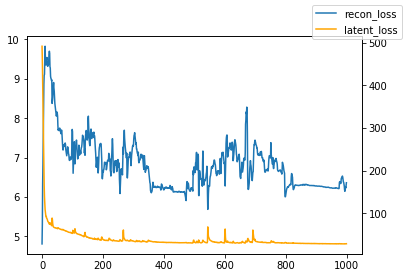

In [39]:
# plot the loss throughout the training
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(1, 1, 1)
ax.plot(losses.index, losses.recon_loss, label='recon_loss')

ax2 = ax.twinx()
ax2.plot(losses.index, losses.latent_loss, label='latent_loss', color='orange')
ax.figure.legend(loc='best')

In [40]:
# evaluate
p_z = ds.MultivariateNormalDiag(loc=[0.] * model.hidden_size, scale_diag=[1.] * model.hidden_size)

test_tensor = tf.constant(X_test.values, dtype='float32')
# mu, sigma = tf.split(model.encoder(test_tensor), 2, 1)
encoded = model.encoder(test_tensor)
mu, sigma = model.dense_mean(encoded), model.dense_std(encoded)

q_z = ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
test_pred = ds.kl_divergence(p_z, q_z)
# test_pred = tf.sigmoid(test_pred)

test_pred = test_pred.numpy()
test_pred = test_pred / (test_pred.max() - test_pred.min())

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_pred)

0.4604745377442654